# Testing data rate

In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import or install Sionna
try:
    import sionna.phy
    import sionna.rt
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For link-level simulations
from sionna.phy.channel import OFDMChannel, CIRDataset
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector
from sionna.phy.mimo import StreamManagement

# Import Sionna RT components
from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver
import matplotlib.pyplot as plt
no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

E0000 00:00:1744139446.760846  206728 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744139446.765595  206728 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744139446.779976  206728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744139446.779996  206728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744139446.779997  206728 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744139446.779999  206728 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# System parameters
subcarrier_spacing = 30e3 # Hz
num_time_steps = 14 # Total number of ofdm symbols per slot

num_tx = 1 # Number of users
num_rx = 1 # Only one receiver considered
num_tx_ant = 2 # Each user has 4 antennas
num_rx_ant = 1 # The receiver is equipped with 16 antennas

# batch_size for CIR generation
batch_size_cir = 200

In [18]:
# Load an integrated scene.
# You can try other scenes, such as `sionna.rt.scene.etoile`. Note that this would require
# updating the position of the transmitter (see below in this cell).
scene = load_scene(sionna.rt.scene.simple_street_canyon)

# Transmitter (=basestation) has an antenna pattern from 3GPP 38.901
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=2, # We want to transmitter to be equiped with 16 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[0,0,27],
                 look_at=[45,90,1.5], # optional, defines view direction
                 display_radius=3.) # optinal, radius of the sphere for visualizing the device
scene.add(tx)
    
# Configure antenna array for all receivers (=UEs)
scene.remove(f"rx") # Remove old receiver if any
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, # Each receiver is equipped with 4 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")
rx = Receiver(name=f"rx",
                position=(20, 40, 10), # Position sampled from radio map
                velocity=(3.,3.,0),
                display_radius=1., # optional, radius of the sphere for visualizing the device
                color=(1,0,0) # optional, color for visualizing the device
                )
scene.add(rx)

# Create new camera
bird_cam = Camera(position=[0,0,300], orientation=np.array([0,np.pi/2,-np.pi/2]))

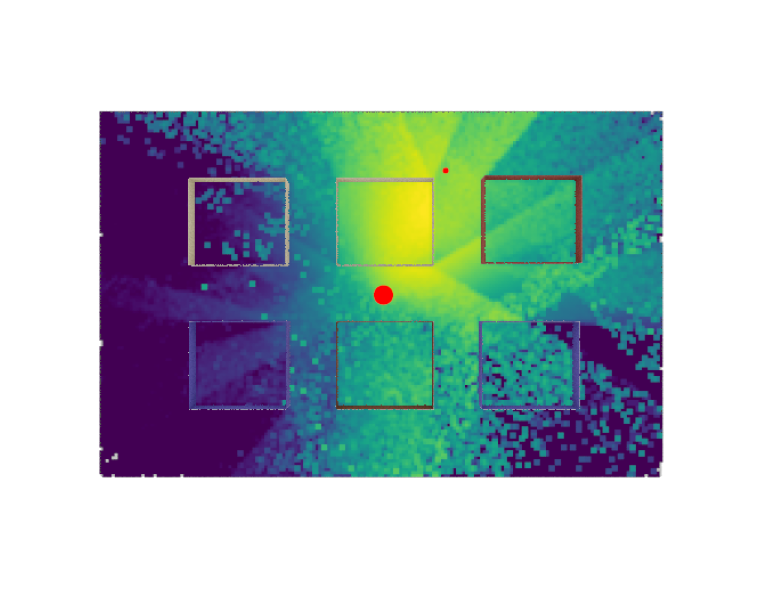

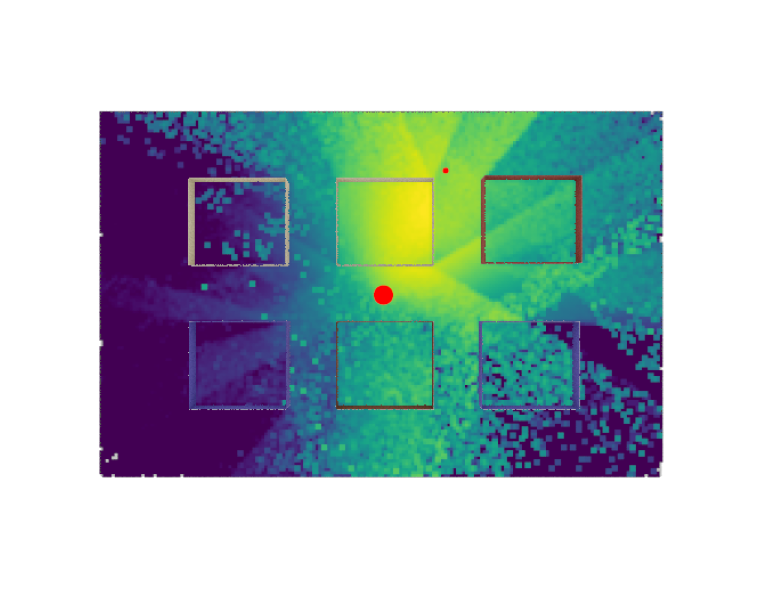

In [19]:
max_depth = 5

# Radio map solver
rm_solver = RadioMapSolver()

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,
               cell_size=(1., 1.),
               samples_per_tx=10**6)
scene.render(camera=bird_cam,
                 radio_map=rm,
                 rm_vmin=-110,
                 clip_at=12.)

taps.shape: (1, 1, 1, 2, 1, 16)


Text(0.5, 1.0, 'Discrete channel taps')

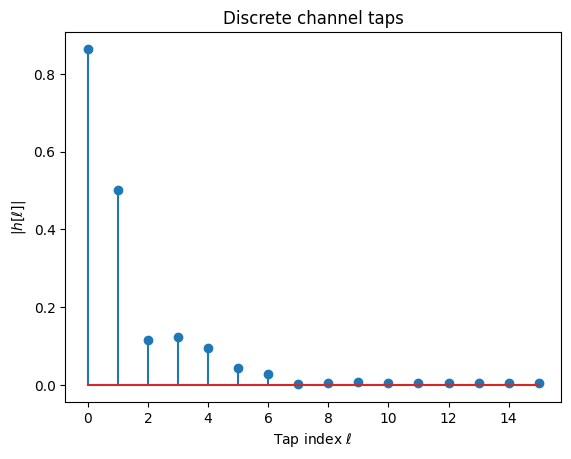

In [23]:
p_solver = PathSolver()
# Simulate CIR
paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**6)

l_min = 0
l_max = 15
taps = paths.taps(bandwidth=20e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=l_min,        # Smallest time lag
                  l_max=l_max,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1]
# a, tau = taps


# print(f"shape of a: {a.shape}")
# print(f"shape of tau: {tau.shape}")

print(f"taps.shape: {taps.shape}")
plt.figure()
plt.stem(np.arange(l_min, l_max + 1), np.abs(taps)[0,0,0,0,0])
plt.xlabel(r"Tap index $\ell$")
plt.ylabel(r"|$h[\ell]|$")
plt.title("Discrete channel taps")

taps.shape: (1, 1, 1, 2, 1, 11)


Text(0.5, 1.0, 'Discrete channel taps')

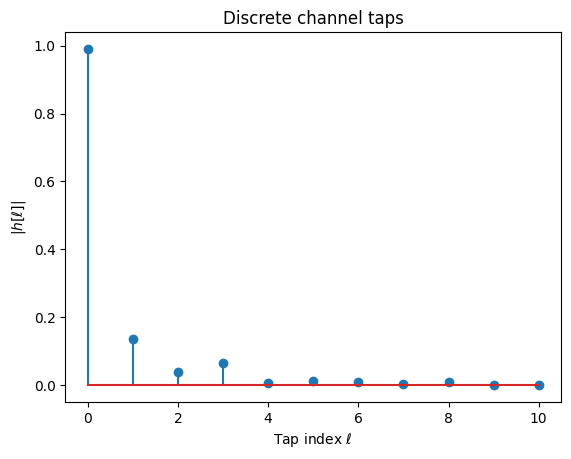

In [17]:
p_solver = PathSolver()
# Simulate CIR
paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**6)

taps = paths.taps(bandwidth=20e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=0,        # Smallest time lag
                  l_max=10,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1]
# a, tau = taps


# print(f"shape of a: {a.shape}")
# print(f"shape of tau: {tau.shape}")

print(f"taps.shape: {taps.shape}")
plt.figure()
plt.stem(np.arange(0, 11), np.abs(taps)[0,0,0,0,0])
plt.xlabel(r"Tap index $\ell$")
plt.ylabel(r"|$h[\ell]|$")
plt.title("Discrete channel taps")

In [6]:
min_gain_db = -130 # in dB; ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB; ignore strong paths

# Sample points in a 5-400m range around the receiver
min_dist = 5 # in m
max_dist = 400 # in m

# Sample batch_size random user positions from the radio map
ue_pos, _ = rm.sample_positions(num_pos=1,
                                metric="path_gain",
                                min_val_db=min_gain_db,
                                max_val_db=max_gain_db,
                                min_dist=min_dist,
                                max_dist=max_dist)

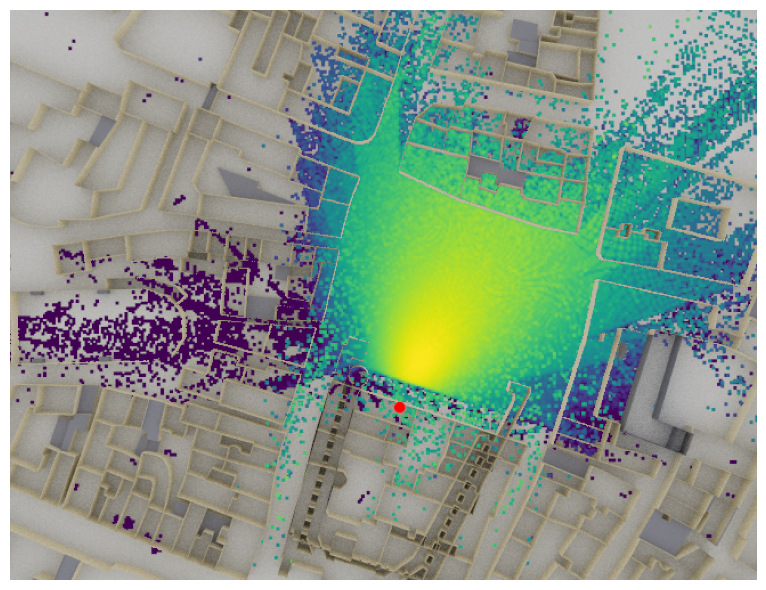

In [7]:
# Configure antenna array for all receivers (=UEs)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1, # Each receiver is equipped with 4 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# Create batch_size receivers
for i in range(1):
    scene.remove(f"rx-{i}") # Remove old receiver if any
    rx = Receiver(name=f"rx-{i}",
                  position=ue_pos[0][i], # Position sampled from radio map
                  velocity=(3.,3.,0),
                  display_radius=1., # optional, radius of the sphere for visualizing the device
                  color=(1,0,0) # optional, color for visualizing the device
                  )
    scene.add(rx)

# And visualize the scene
if no_preview:
    # Render an image
    scene.render(camera=bird_cam,
                 radio_map=rm,
                 rm_vmin=-110,
                 clip_at=12.)

In [8]:
p_solver = PathSolver()
# Simulate CIR
paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**6)

# Transform paths into channel impulse responses
# a, tau = paths.cir(sampling_frequency=subcarrier_spacing,
#                         num_time_steps=14,
#                         out_type='numpy')

In [ ]:
taps = paths.taps(bandwidth=20e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=0,        # Smallest time lag
                  l_max=10,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1]
# a, tau = taps


# print(f"shape of a: {a.shape}")
# print(f"shape of tau: {tau.shape}")

print(f"taps.shape: {taps.shape}")
plt.figure()
plt.stem(np.arange(0, 11), np.abs(taps)[0,0,0,0,0])
plt.xlabel(r"Tap index $\ell$")
plt.ylabel(r"|$h[\ell]|$")
plt.title("Discrete channel taps")

taps.shape: (1, 1, 1, 2, 1, 11)


In [22]:
taps

array([[[[[[-0.661705  +7.0461601e-01j,  0.2471354 -5.2775037e-02j,
            -0.02615896+5.5861515e-03j,  0.01381037-2.9491296e-03j,
            -0.00938166+2.0034015e-03j,  0.00710366-1.5169660e-03j,
            -0.00571574+1.2205401e-03j,  0.00478159-1.0210942e-03j,
            -0.00410984+8.7761565e-04j,  0.00360353-7.6946634e-04j,
            -0.00320842+6.8514817e-04j]],

          [[-0.58519435+7.7017426e-01j,  0.24285322-6.9881372e-02j,
            -0.0257057 +7.3968335e-03j,  0.01357108-3.9050607e-03j,
            -0.00921911+2.6527848e-03j,  0.00698057-2.0086705e-03j,
            -0.00561671+1.6161734e-03j,  0.00469874-1.3520683e-03j,
            -0.00403864+1.1620916e-03j,  0.00354109-1.0188948e-03j,
            -0.00315282+9.0722996e-04j]]]]]], dtype=complex64)

Text(0.5, 1.0, 'Discrete channel taps')

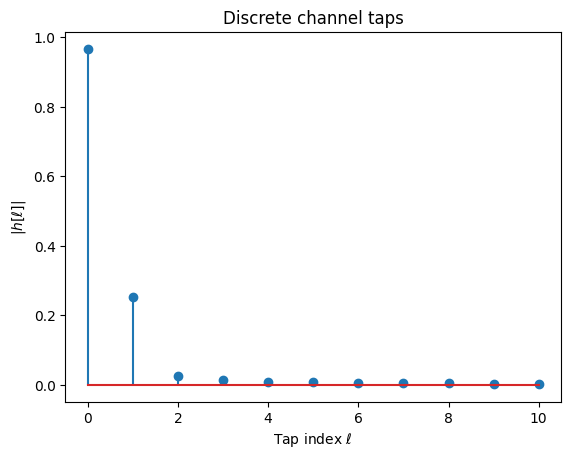

In [23]:
plt.figure()
plt.stem(np.arange(0, 11), np.abs(taps)[0,0,0,0,0])
plt.xlabel(r"Tap index $\ell$")
plt.ylabel(r"|$h[\ell]|$")
plt.title("Discrete channel taps")

In [ ]:
# num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths
print(f"shape of a: {a.shape}")
print(f"shape of tau: {tau.shape}")

shape of a: (1, 4, 1, 16, 11, 14)
shape of tau: (1, 1, 11)


In [11]:
a[0, 0, 0, 0, 0]

array([6.7641290e-06-5.5737219e-06j, 6.7720457e-06-5.5641003e-06j,
       6.7799492e-06-5.5544670e-06j, 6.7878386e-06-5.5448227e-06j,
       6.7957149e-06-5.5351675e-06j, 6.8035765e-06-5.5255009e-06j,
       6.8114250e-06-5.5158234e-06j, 6.8192594e-06-5.5061346e-06j,
       6.8270801e-06-5.4964344e-06j, 6.8348872e-06-5.4867232e-06j,
       6.8426807e-06-5.4770012e-06j, 6.8504601e-06-5.4672682e-06j,
       6.8582253e-06-5.4575235e-06j, 6.8659770e-06-5.4477682e-06j],
      dtype=complex64)

In [ ]:
target_num_cirs = 2000 # Defines how many different CIRs are generated.
# Remark: some path are removed if no path was found for this position

max_depth = 5
min_gain_db = -130 # in dB / ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB / ignore any position with more than 0 dB path gain

# Sample points within a 10-400m radius around the transmitter
min_dist = 10 # in m
max_dist = 400 # in m

# List of channel impulse reponses
a_list = []
tau_list = []

# Maximum number of paths over all batches of CIRs.
# This is used later to concatenate all CIRs.
max_num_paths = 0

# Path solver
p_solver = PathSolver()

# Each simulation returns batch_size_cir results
num_runs = int(np.ceil(target_num_cirs/batch_size_cir))
for idx in range(num_runs):
    print(f"Progress: {idx+1}/{num_runs}", end="\r")

    # Sample random user positions
    ue_pos, _ = rm.sample_positions(
                        num_pos=batch_size_cir,
                        metric="path_gain",
                        min_val_db=min_gain_db,
                        max_val_db=max_gain_db,
                        min_dist=min_dist,
                        max_dist=max_dist,
                        seed=idx) # Change the seed from one run to the next to avoid sampling the same positions

    # Update all receiver positions
    for rx in range(batch_size_cir):
        scene.receivers[f"rx-{rx}"].position = ue_pos[0][rx]

    # Simulate CIR
    paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**6)

    # Transform paths into channel impulse responses
    a, tau = paths.cir(sampling_frequency=subcarrier_spacing,
                         num_time_steps=14,
                         out_type='numpy')
    a_list.append(a)
    tau_list.append(tau)

    # Update maximum number of paths over all batches of CIRs
    num_paths = a.shape[-2]
    if num_paths > max_num_paths:
        max_num_paths = num_paths

# Concatenate all the CIRs into a single tensor along the num_rx dimension.
# First, we need to pad the CIRs to ensure they all have the same number of paths.
a = []
tau = []
for a_,tau_ in zip(a_list, tau_list):
    num_paths = a_.shape[-2]
    a.append(np.pad(a_, [[0,0],[0,0],[0,0],[0,0],[0,max_num_paths-num_paths],[0,0]], constant_values=0))
    tau.append(np.pad(tau_, [[0,0],[0,0],[0,max_num_paths-num_paths]], constant_values=0))
a = np.concatenate(a, axis=0) # Concatenate along the num_rx dimension
tau = np.concatenate(tau, axis=0)

# Let's now convert to uplink direction, by switing the receiver and transmitter
# dimensions
a = np.transpose(a, (2,3,0,1,4,5))
tau = np.transpose(tau, (1,0,2))

# Add a batch_size dimension
a = np.expand_dims(a, axis=0)
tau = np.expand_dims(tau, axis=0)

# Exchange the num_tx and batchsize dimensions
a = np.transpose(a, [3, 1, 2, 0, 4, 5, 6])
tau = np.transpose(tau, [2, 1, 0, 3])

# Remove CIRs that have no active link (i.e., a is all-zero)
p_link = np.sum(np.abs(a)**2, axis=(1,2,3,4,5,6))
a = a[p_link>0.,...]
tau = tau[p_link>0.,...]

print("Shape of a:", a.shape)
print("Shape of tau: ", tau.shape)

In [6]:
min_gain_db = -130 # in dB; ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB; ignore strong paths

# Sample points in a 5-400m range around the receiver
min_dist = 5 # in m
max_dist = 400 # in m

# Sample batch_size random user positions from the radio map
ue_pos, _ = rm.sample_positions(num_pos=batch_size_cir,
                                metric="path_gain",
                                min_val_db=min_gain_db,
                                max_val_db=max_gain_db,
                                min_dist=min_dist,
                                max_dist=max_dist)

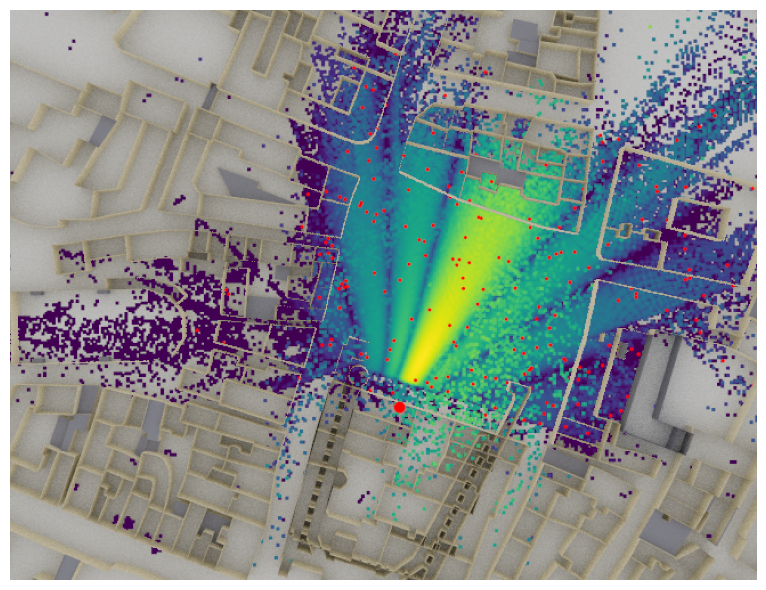

In [7]:
# Configure antenna array for all receivers (=UEs)
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=num_tx_ant//2, # Each receiver is equipped with 4 antennas
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="cross")

# Create batch_size receivers
for i in range(batch_size_cir):
    scene.remove(f"rx-{i}") # Remove old receiver if any
    rx = Receiver(name=f"rx-{i}",
                  position=ue_pos[0][i], # Position sampled from radio map
                  velocity=(3.,3.,0),
                  display_radius=1., # optional, radius of the sphere for visualizing the device
                  color=(1,0,0) # optional, color for visualizing the device
                  )
    scene.add(rx)

# And visualize the scene
if no_preview:
    # Render an image
    scene.render(camera=bird_cam,
                 radio_map=rm,
                 rm_vmin=-110,
                 clip_at=12.)

In [ ]:
target_num_cirs = 2000 # Defines how many different CIRs are generated.
# Remark: some path are removed if no path was found for this position

max_depth = 5
min_gain_db = -130 # in dB / ignore any position with less than -130 dB path gain
max_gain_db = 0 # in dB / ignore any position with more than 0 dB path gain

# Sample points within a 10-400m radius around the transmitter
min_dist = 10 # in m
max_dist = 400 # in m

# List of channel impulse reponses
a_list = []
tau_list = []

# Maximum number of paths over all batches of CIRs.
# This is used later to concatenate all CIRs.
max_num_paths = 0

# Path solver
p_solver = PathSolver()

# Each simulation returns batch_size_cir results
num_runs = int(np.ceil(target_num_cirs/batch_size_cir))
for idx in range(num_runs):
    print(f"Progress: {idx+1}/{num_runs}", end="\r")

    # Sample random user positions
    ue_pos, _ = rm.sample_positions(
                        num_pos=batch_size_cir,
                        metric="path_gain",
                        min_val_db=min_gain_db,
                        max_val_db=max_gain_db,
                        min_dist=min_dist,
                        max_dist=max_dist,
                        seed=idx) # Change the seed from one run to the next to avoid sampling the same positions

    # Update all receiver positions
    for rx in range(batch_size_cir):
        scene.receivers[f"rx-{rx}"].position = ue_pos[0][rx]

    # Simulate CIR
    paths = p_solver(scene, max_depth=max_depth, max_num_paths_per_src=10**6)

    # Transform paths into channel impulse responses
    a, tau = paths.cir(sampling_frequency=subcarrier_spacing,
                         num_time_steps=14,
                         out_type='numpy')
    a_list.append(a)
    tau_list.append(tau)

    # Update maximum number of paths over all batches of CIRs
    num_paths = a.shape[-2]
    if num_paths > max_num_paths:
        max_num_paths = num_paths

# Concatenate all the CIRs into a single tensor along the num_rx dimension.
# First, we need to pad the CIRs to ensure they all have the same number of paths.
a = []
tau = []
for a_,tau_ in zip(a_list, tau_list):
    num_paths = a_.shape[-2]
    a.append(np.pad(a_, [[0,0],[0,0],[0,0],[0,0],[0,max_num_paths-num_paths],[0,0]], constant_values=0))
    tau.append(np.pad(tau_, [[0,0],[0,0],[0,max_num_paths-num_paths]], constant_values=0))
a = np.concatenate(a, axis=0) # Concatenate along the num_rx dimension
tau = np.concatenate(tau, axis=0)

# Let's now convert to uplink direction, by switing the receiver and transmitter
# dimensions
a = np.transpose(a, (2,3,0,1,4,5))
tau = np.transpose(tau, (1,0,2))

# Add a batch_size dimension
a = np.expand_dims(a, axis=0)
tau = np.expand_dims(tau, axis=0)

# Exchange the num_tx and batchsize dimensions
a = np.transpose(a, [3, 1, 2, 0, 4, 5, 6])
tau = np.transpose(tau, [2, 1, 0, 3])

# Remove CIRs that have no active link (i.e., a is all-zero)
p_link = np.sum(np.abs(a)**2, axis=(1,2,3,4,5,6))
a = a[p_link>0.,...]
tau = tau[p_link>0.,...]

print("Shape of a:", a.shape)
print("Shape of tau: ", tau.shape)

In [ ]:
class CIRGenerator:
    """Creates a generator from a given dataset of channel impulse responses

    The generator samples ``num_tx`` different transmitters from the given path
    coefficients `a` and path delays `tau` and stacks the CIRs into a single tensor.

    Note that the generator internally samples ``num_tx`` random transmitters
    from the dataset. For this, the inputs ``a`` and ``tau`` must be given for
    a single transmitter (i.e., ``num_tx`` =1) which will then be stacked
    internally.

    Parameters
    ----------
    a : [batch size, num_rx, num_rx_ant, 1, num_tx_ant, num_paths, num_time_steps], complex
        Path coefficients per transmitter

    tau : [batch size, num_rx, 1, num_paths], float
        Path delays [s] per transmitter

    num_tx : int
        Number of transmitters

    Output
    -------
    a : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps], tf.complex
        Path coefficients

    tau : [batch size, num_rx, num_tx, num_paths], tf.float
        Path delays [s]
    """

    def __init__(self,
                 a,
                 tau,
                 num_tx):

        # Copy to tensorflow
        self._a = tf.constant(a, tf.complex64)
        self._tau = tf.constant(tau, tf.float32)
        self._dataset_size = self._a.shape[0]

        self._num_tx = num_tx

    def __call__(self):

        # Generator implements an infinite loop that yields new random samples
        while True:
            # Sample 4 random users and stack them together
            idx,_,_ = tf.random.uniform_candidate_sampler(
                            tf.expand_dims(tf.range(self._dataset_size, dtype=tf.int64), axis=0),
                            num_true=self._dataset_size,
                            num_sampled=self._num_tx,
                            unique=True,
                            range_max=self._dataset_size)

            a = tf.gather(self._a, idx)
            tau = tf.gather(self._tau, idx)

            # Transpose to remove batch dimension
            a = tf.transpose(a, (3,1,2,0,4,5,6))
            tau = tf.transpose(tau, (2,1,0,3))

            # And remove batch-dimension
            a = tf.squeeze(a, axis=0)
            tau = tf.squeeze(tau, axis=0)

            yield a, tau

In [ ]:
batch_size = 20 # Must be the same for the BER simulations as CIRDataset returns fixed batch_size

# Init CIR generator
cir_generator = CIRGenerator(a,
                             tau,
                             num_tx)
# Initialises a channel model that can be directly used by OFDMChannel layer
channel_model = CIRDataset(cir_generator,
                           batch_size,
                           num_rx,
                           num_rx_ant,
                           num_tx,
                           num_tx_ant,
                           max_num_paths,
                           num_time_steps)

In [ ]:
class Model:
    """Simulate PUSCH transmissions

    This model runs BER simulations for a multi-user MIMO uplink channel
    compliant with the 5G NR PUSCH specifications.
    You can pick different scenarios, i.e., channel models, perfect or
    estimated CSI, as well as different MIMO detectors (LMMSE or KBest).

    Parameters
    ----------
    channel_model : :class:`~sionna.channel.ChannelModel` object
        An instance of a :class:`~sionna.channel.ChannelModel` object, such as
        :class:`~sionna.channel.RayleighBlockFading` or
        :class:`~sionna.channel.tr38901.UMi` or
        :class:`~sionna.channel.CIRDataset`.

    perfect_csi : bool
        Determines if perfect CSI is assumed or if the CSI is estimated

    detector : str, one of ["lmmse", "kbest"]
        MIMO detector to be used. Note that each detector has additional
        parameters that can be configured in the source code of the _init_ call.

    Input
    -----
    batch_size : int
        Number of simultaneously simulated slots

    ebno_db : float
        Signal-to-noise-ratio

    Output
    ------
    b : [batch_size, num_tx, tb_size], tf.float
        Transmitted information bits

    b_hat : [batch_size, num_tx, tb_size], tf.float
        Decoded information bits
    """
    def __init__(self,
                 channel_model,
                 perfect_csi, # bool
                 detector,    # "lmmse", "kbest"
                ):
        super().__init__()

        self._channel_model = channel_model
        self._perfect_csi = perfect_csi

        # System configuration
        self._num_prb = 16
        self._mcs_index = 14
        self._num_layers = 1
        self._mcs_table = 1
        self._domain = "freq"

        # Below parameters must equal the Path2CIR parameters
        self._num_tx_ant = 4
        self._num_tx = 4
        self._subcarrier_spacing = 30e3 # must be the same as used for Path2CIR

        # PUSCHConfig for the first transmitter
        pusch_config = PUSCHConfig()
        pusch_config.carrier.subcarrier_spacing = self._subcarrier_spacing/1000
        pusch_config.carrier.n_size_grid = self._num_prb
        pusch_config.num_antenna_ports = self._num_tx_ant
        pusch_config.num_layers = self._num_layers
        pusch_config.precoding = "codebook"
        pusch_config.tpmi = 1
        pusch_config.dmrs.dmrs_port_set = list(range(self._num_layers))
        pusch_config.dmrs.config_type = 1
        pusch_config.dmrs.length = 1
        pusch_config.dmrs.additional_position = 1
        pusch_config.dmrs.num_cdm_groups_without_data = 2
        pusch_config.tb.mcs_index = self._mcs_index
        pusch_config.tb.mcs_table = self._mcs_table

        # Create PUSCHConfigs for the other transmitters by cloning of the first PUSCHConfig
        # and modifying the used DMRS ports.
        pusch_configs = [pusch_config]
        for i in range(1, self._num_tx):
            pc = pusch_config.clone()
            pc.dmrs.dmrs_port_set = list(range(i*self._num_layers, (i+1)*self._num_layers))
            pusch_configs.append(pc)

        # Create PUSCHTransmitter
        self._pusch_transmitter = PUSCHTransmitter(pusch_configs, output_domain=self._domain)

        # Create PUSCHReceiver
        rx_tx_association = np.ones([1, self._num_tx], bool)
        stream_management = StreamManagement(rx_tx_association,
                                             self._num_layers)

        assert detector in["lmmse", "kbest"], "Unsupported MIMO detector"
        if detector=="lmmse":
            detector = LinearDetector(equalizer="lmmse",
                                      output="bit",
                                      demapping_method="maxlog",
                                      resource_grid=self._pusch_transmitter.resource_grid,
                                      stream_management=stream_management,
                                      constellation_type="qam",
                                      num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)
        elif detector=="kbest":
            detector = KBestDetector(output="bit",
                                     num_streams=self._num_tx*self._num_layers,
                                     k=64,
                                     resource_grid=self._pusch_transmitter.resource_grid,
                                     stream_management=stream_management,
                                     constellation_type="qam",
                                     num_bits_per_symbol=pusch_config.tb.num_bits_per_symbol)

        if self._perfect_csi:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain,
                                                 channel_estimator="perfect")
        else:
            self._pusch_receiver = PUSCHReceiver(self._pusch_transmitter,
                                                 mimo_detector=detector,
                                                 input_domain=self._domain)


        # Configure the actual channel
        self._channel = OFDMChannel(
                            self._channel_model,
                            self._pusch_transmitter.resource_grid,
                            normalize_channel=True,
                            return_channel=True)

    # XLA currently not supported by the CIRDataset function
    @tf.function(jit_compile=False)
    def __call__(self, batch_size, ebno_db):

        x, b = self._pusch_transmitter(batch_size)
        no = ebnodb2no(ebno_db,
                       self._pusch_transmitter._num_bits_per_symbol,
                       self._pusch_transmitter._target_coderate,
                       self._pusch_transmitter.resource_grid)
        y, h = self._channel(x, no)
        if self._perfect_csi:
            b_hat = self._pusch_receiver(y, no, h)
        else:
            b_hat = self._pusch_receiver(y, no)
        return b, b_hat

In [ ]:
ebno_db = 10.
e2e_model = Model(channel_model,
                  perfect_csi=False, # bool
                  detector="lmmse")  # "lmmse", "kbest"

# We can draw samples from the end-2-end link-level simulations
b, b_hat = e2e_model(batch_size, ebno_db)